In [4]:
import keras
from keras import backend as K
import numpy as np
from matplotlib import pyplot as plt
from scipy.misc import imread, imresize
import os
import random
from IPython.core.debugger import Tracer

K.clear_session()

Using TensorFlow backend.


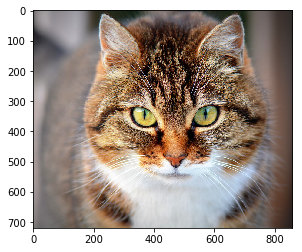

In [5]:
mean_pixel = [103.939, 116.779, 123.68]
mean_pixel = np.array(mean_pixel)

cat = imread('cat.jpg')
plt.imshow(cat)
plt.show()

In [6]:
from keras.applications.vgg16 import VGG16
from keras.models import Model

model = VGG16(weights='imagenet', include_top=False, input_shape=cat.shape)
new_model = model

In [7]:
cat = cat - mean_pixel
out = model.predict(cat[np.newaxis])
out.shape

(1, 22, 26, 512)

In [8]:
test_base = 'data/image/'
image_name_test = []
for file in os.listdir(test_base):
    if file.endswith('.jpg'):
        image_name_test.append(file)
image_num = len(image_name_test)
len(image_name_test)

5063

In [9]:
out = np.load('aggregated-features.npy')
paris_aggregated = np.load('paris_aggregated.npy')
paris_aggregated = np.vstack(paris_aggregated[0])
out.shape

(5063, 512)

In [10]:
query_dir = 'data/gt_files_170407/'
query_list = []
for file in os.listdir(query_dir):
    if file.endswith('_query.txt'):
        query_list.append(file)
len(query_list)

55

(1, 20)


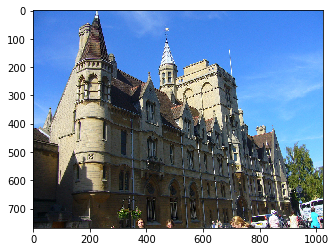

1714


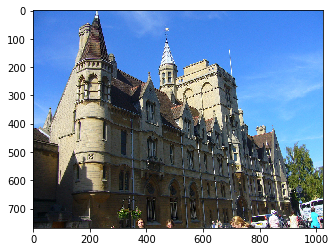

1331


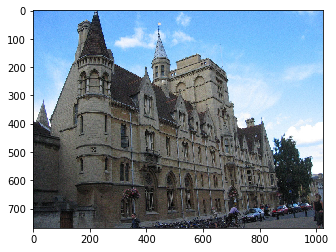

4097


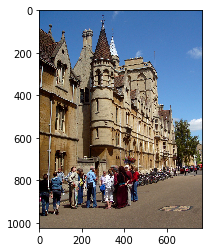

3398


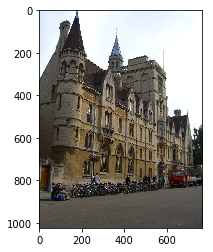

4361


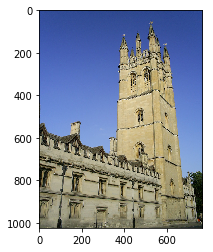

3734


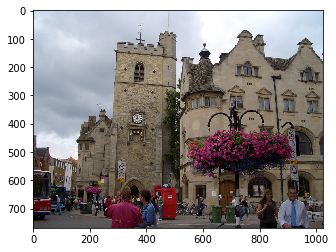

444


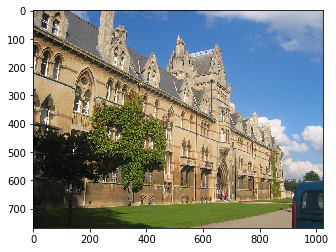

3282


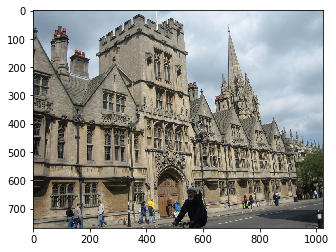

2860


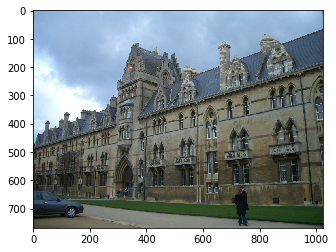

348


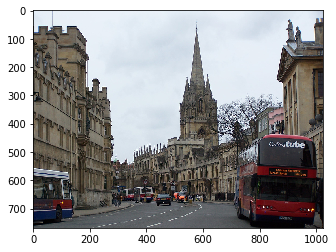

2088


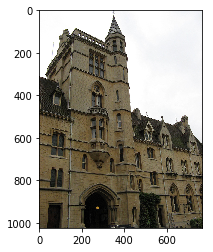

2767


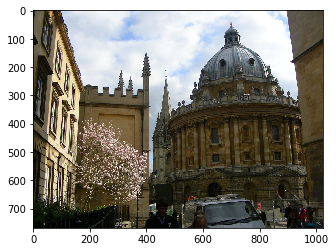

1299


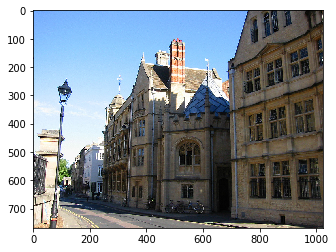

766


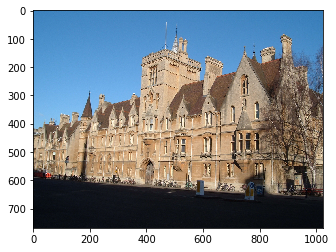

264


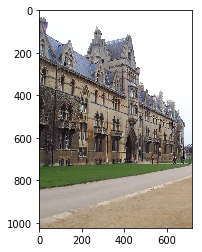

4464


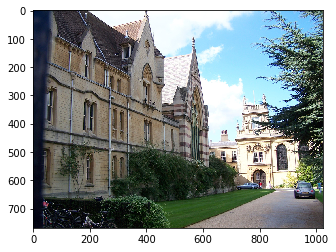

3906


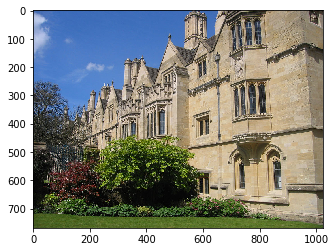

1464


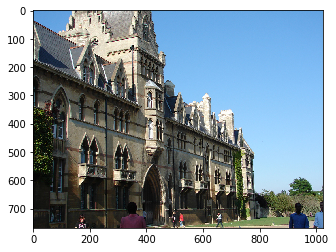

13


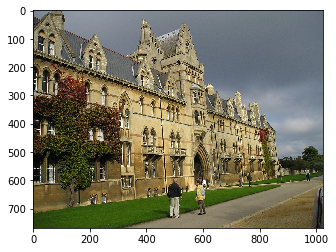

515


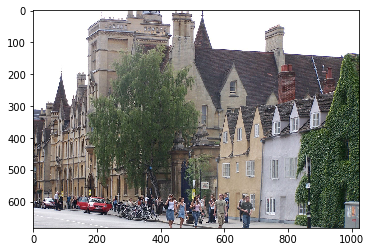

In [11]:
query = 'hertford_000027'
query = query + '.jpg'
index = image_name_test.index(query)
n_neighbors = 20

query = random.choice(query_list)
with open(query_dir+query) as f:
    query = f.read().split()[0]
    query = query[5:]
    query = query + '.jpg'
    
index = image_name_test.index(query)
    
from sklearn.neighbors import NearestNeighbors as NN
nn = NN()
nn.fit(out)
neighbors = nn.kneighbors(out[index][np.newaxis,:], n_neighbors=n_neighbors, 
                          return_distance=False)
print neighbors.shape

image = imread(test_base+image_name_test[index])
plt.imshow(image)
plt.show()

for neighbor in np.nditer(neighbors):
    # the first should be the query image
    print neighbor
    image = imread(test_base+image_name_test[neighbor])
    plt.imshow(image)
    plt.show()

In [12]:
def compute_ap(pos, amb, rank, debug = False):
    old_recall = 0.0
    old_precision = 1.0
    ap = 0.0
    
    intersect_size = 0
    i = 0
    j = 0
    
    for i in range(len(rank)):
        if rank[i] in amb:
            continue
        if rank[i] in pos:
            intersect_size += 1
        if False:
            # this is wrong
            recall = intersect_size / float(len(pos))
            precision = intersect_size / (j + 1.0)
            
            ap += (recall - old_recall) * ((old_precision + precision)/2.0)
            
            old_recall = recall
            old_precision = precision;
            j += 1
        else:
            if rank[i] in pos:
                ap0 = intersect_size / float(i+1.0)
                ap += ap0
                
                if debug:
                    print 'ap0'
                    print ap0
                    print 'min'
                    print min(float(len(pos)),len(rank))
    if False:
        return ap
    else:
        ap = ap / min(float(len(pos)),len(rank))
        return ap

In [13]:
def load_list(file):
    # load the list of good, OK, bad set image name
    with open(file, 'r') as f:
        l = []
        for line in f:
            l.append(line.rstrip('\n'))
        return l

In [14]:
def compute_ap2(query, rank, query_dir, image_dir='data/image/',debug=False, display_pos=False):
    # here query is the name of picture, include .jpg
    query = query[:-10]
    good_set = load_list(query_dir+query+'_good.txt')
    ok_set = load_list(query_dir+query+'_ok.txt')
    junk_set = load_list(query_dir+query+'_junk.txt')
    
    pos_set = good_set + ok_set
    if debug:
        print 'pos_set'
        print pos_set
    if display_pos:
        for image in pos_set:
            img = imread(image_dir+image+'.jpg')
            plt.imshow(img)
            plt.show()
    
    ap = compute_ap(pos_set, junk_set, rank)
    return ap

In [15]:
# convert the index to image name, meanwhile delete the first index because it is the query image
def i2name(l, d):
    l2 = []
    l = l.reshape(-1)
    l = l.tolist()
    if False:
        print 'len {}'.format(len(l))
    for item in l:        
        l2.append(d[item][:-4])
        
    return l2

    # because sometime the query image is not in rank 1
    return l2[1:]

In [16]:
def get_query_image(query, query_dir, debug = False):
    if debug:
        print 'get_query_image query is {}'.format(query)
    with open(query_dir+query) as f:
        query = f.read().split()
        position = []
        for i in [1,2,3,4]:
            position.append(query[i])
            
        query = query[0]
        query = query[5:]
        query = query + '.jpg'
    return query, position

In [17]:
def preprocessing(out, query=None, params={}, normalize=0, pca=-1, pca_features=None, ica=-1, ica_iter=200):
    # ica_iter=200 is default value of FastICA
    
    if normalize == 0:
        normalize = params.get('normalize', 0)
    if pca == -1:
        pca = params.get('pca', -1)
    if pca_features == None:
        pca_features = params.get('pca_features', None)
    if ica == -1:
        ica = params.get('ica', -1)
    if ica_iter == 200:
        ica_iter = params.get('ica_iter', 200)
    
    if normalize >= 1:
        from sklearn.preprocessing import normalize as sknormalize
        out = sknormalize(out)
        if query != None:
            query = sknormalize(query)
            
        # do the same process to pca_features
        if pca_features == None:
            pca_features = out
        else:
            pca_features = sknormalize(pca_features)
    
    if pca >= 0:
        from sklearn.decomposition import PCA
        pca = PCA(whiten=True, random_state=0)

        pca.fit(pca_features)
        out = pca.transform(out)
        if query != None:
            query = pca.transform(query)
        
    if ica >= 0:
        from sklearn.decomposition import FastICA
        ica = FastICA(max_iter=ica_iter)
        ica.fit(out)
        out = ica.transform(out)
        if query != None:
            query = pca.transform(query)
        
    if normalize >= 2:
        out = sknormalize(out)
        if query != None:
            query = sknormalize(query)
            
    if query != None:
        return out, query
    else:
        return out

In [18]:
def get_query(query, query_dir, image_name_test, out, image_dir='/data/image/',
              crop = False, debug = False):
    # the input query is the query file e.g. XXXX_query
    # return the name of query image and parch coordinate
    if debug:
        print 'get_query query is {}'.format(query)
        
    query, position = get_query_image(query, query_dir)
    
    index = image_name_test.index(query)
    target = out[index][np.newaxis,:]
    
    clear_every = 1
    
    if crop:
        x, y, x2, y2 = position
        (x, y, x2, y2) = map(float, (x, y, x2, y2))
        (x, y, x2, y2) = map(round, (x, y, x2, y2))
        
        (x, y, x2, y2) = map(int, (x, y, x2, y2))
        
        image = imread(image_dir+query)
        
        if debug:
            print 'show uncropped image'
            plt.imshow(image)
            plt.show()

        # the subscripts of image and numpy is different
        image = image[y:y2,x:x2]

        if debug:
            plt.imshow(image)
            plt.show()

        if debug:
            print query
            print position

        '''
        compute_neighbors.counter += 1
        if debug:
            print 'compute_neighbors: This is {} calls'.format(compute_neighbors.counter)
        if compute_neighbors.counter == clear_every:
            import keras.backend as K
            K.clear_session()
        '''
        model = VGG16(weights='imagenet', include_top=False, 
                          input_shape=image.shape)
        target = model.predict(image[np.newaxis,:]).sum(axis=(1,2))
        
    return target

In [96]:
def mycosine(vector1, vector2):
    # compute cosine distance of two normalized vector
    return 1-np.absolute((vector1 * vector2).sum())

def compute_neighbors2(target, out, debug = False, distance_metric='euclidean'):
    
    # query    here query is the query file e.g XXXXX_query.txt

    if debug:
        print out.shape
    N, D = out.shape
    n_neighbors = image_num

    if True:
        from sklearn.neighbors import NearestNeighbors as NN
        nn = NN(metric=distance_metric, algorithm='brute')
        nn.fit(out)
        neighbors = nn.kneighbors(target, n_neighbors=n_neighbors,
                                  return_distance=False)
    else:
        dists = ((target - out)**2).sum(axis=1)
        neighbors = np.argsort(dists) 
    return neighbors

In [20]:
name_dict = dict(enumerate(image_name_test))

|aggregated method|pca_feature    |crop    |distance_matric|MaP    |MaP (QE)|
|----|
|ucrow            |oxford         |True    |eclidean       |0.46   |0.61    |
|ucrow            |oxford         |False   |eclidean       |0.61   |0.67    |
|ucrow            |oxford         |True    |cosine         |0.44   |0.61    |
|ucrow            |oxford         |False   |cosine         |0.57   |0.66    |
|ucrow            |paris          |True    |eclidean       |0.57   |0.634   |
|ucrow            |paris          |False   |eclidean       |0.65   |0.675
|ucrow            |paris          |True    |cosine         |0.58   |0.634   |
|ucrow            |paris          |False   |cosine         |0.65   |0.67    |

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:22: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:18: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:33: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:46: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:49: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


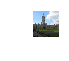

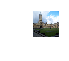

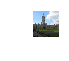

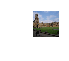

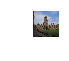

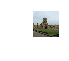

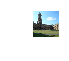

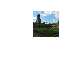

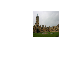

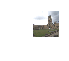

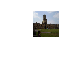

0.61534445014377848

In [116]:
debug = False
show_result = 10
crop = False
query_expansion = 10
ap = []

# features prepocessing params
params = {}
params['normalize'] = 2
params['pca'] = 0
# select from: 
# None: use the same features computing PCA
# paris: use the features of paris dateset computing PCA
params['pca_features'] = paris_aggregated

# select from 'eulidean', mycosine
distance_metric = 'euclidean'

features = preprocessing(out, params=params)
K.clear_session()
image_dir = 'data/image/'

for file in query_list:
    if debug:
        print 'query file name is {}'.format(file)
    target = get_query(file, query_dir, image_name_test, out, image_dir='data/image/',
              crop = crop, debug = debug)
    
    if show_result > 0:
        query_img, _ = get_query_image(file, query_dir, debug = False)
        images = []
        images.append(query_img)
    
    if False:
        print 'target is'
        print target
    _, target = preprocessing(out, query = target, params=params)
    if False:
        print 'after preprocessing, target is'
        print target
    
    neighbors = compute_neighbors2(target, features, debug = debug, distance_metric = distance_metric)
    if query_expansion > 0:
        target = features[neighbors.reshape((-1,1))[:query_expansion]].mean(axis=0)
        neighbors = compute_neighbors2(target, features, debug = debug, distance_metric = distance_metric)
    rank = i2name(neighbors, name_dict)
    
    ap0 = compute_ap2(file, rank, query_dir, debug = debug)
    ap.append(ap0)
    
    if show_result > 0:
        for i in range(show_result):
            images.append(rank[i] + '.jpg')
        
        plt.figure(figsize=(15,180))
        
        for i,image in enumerate(images):
            img = imread(image_dir+image)
            img = imresize(img,(400,400))
            plt.subplot(1, show_result+1, i+1)
            plt.imshow(img.astype(uint8))
            plt.axis('off')
        
        plt.show()
    
    if debug:
        for image in rank[:100]:
            img = imread(image_dir+image+'.jpg')
            plt.imshow(img)
            plt.show()
    
    if debug:
        print 'rank'
        print rank[0:100]
        print 'ap0 is {}'.format(ap0)
    
    if True:
        break
    
np.mean(np.array(ap))

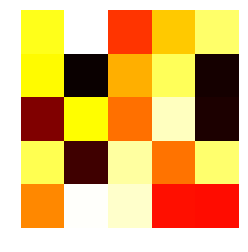

In [120]:
from numpy import random
aa = random.random((5,5))
img = plt.imshow(aa, interpolation='nearest')
img.set_cmap('hot')
plt.axis('off')
# plt.savefig("test.png", bbox_inches='tight')
plt.show()